https://www.astroexplorer.org/details/ajac8154f13

In [1]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
import pandas as pd

redownload = False

fp = '../data/nexsci_data.csv'
if redownload:
    #pstable combines data from the Confirmed Planets and Extended Planet Parameters tables
    tab = NasaExoplanetArchive.query_criteria(table="pscomppars", 
                                             where="discoverymethod like 'Transit'"
                                            ) 
    df = tab.to_pandas()    
    df.to_csv(fp, index=True)
else:
    df = pd.read_csv(fp, index_col=0)
    df.index.name = 'index'
df.head()

,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,discoverymethod,disc_locale,...,sy_pmra,sy_pmraerr1,sy_pmraerr2,sy_pmrastr,x,y,z,htm20,sky_coord.ra,sky_coord.dec
index,,,,,,,,,,,,,,,,,,,,,
0,Kepler-276 c,c,Kepler-276,NaN,NaN,TIC 138213510,2014-02,2013,Transit,Space,...,7.99553,0.051581,-0.051581,7.9955300&plusmn;0.0515805,0.310575,-0.711954,0.629813,1302657699,293.568197,39.036312
1,Kepler-829 b,b,Kepler-829,NaN,NaN,TIC 123451768,2016-05,2016,Transit,Space,...,7.93777,0.040833,-0.040833,7.9377700&plusmn;0.0408326,0.157566,-0.720680,0.675124,-792260935,282.332831,42.463813
2,K2-283 b,b,K2-283,NaN,NaN,TIC 266017624,2018-12,2018,Transit,Space,...,-10.97340,0.053624,-0.053624,-10.9734000&plusmn;0.0536244,0.959702,0.224997,0.168368,609813555,13.194368,9.692918
3,Kepler-477 b,b,Kepler-477,NaN,NaN,TIC 158633329,2016-05,2016,Transit,Space,...,-26.00000,NaN,NaN,-26.0,0.229185,-0.702544,0.673726,-1968935374,288.067445,42.355305
4,TOI-1260 c,c,TOI-1260,NaN,NaN,TIC 355867695,2021-08,2021,Transit,Space,...,-177.23600,0.036921,-0.036921,-177.2360000&plusmn;0.0369214,-0.376942,0.158885,0.912507,-454174731,157.144071,65.854199


In [2]:
import astropy.units as u

df['pl_rade'] = df['pl_radj']*u.Rjup.to(u.Rearth)
transit = df.query("discoverymethod=='Transit'")

idx = (transit.pl_orbper>0) & (transit.pl_rade>0) & (transit.st_mass>0)
transit = transit[idx]

## age

In [11]:
import pandas as pd

distance = 500

fp = "../data/young_validated_planets_TOIs2.xlsx"
hosts = pd.read_excel(fp, sheet_name='validated_hosts', skiprows=[1]).dropna(axis=0, how='all')
hosts = hosts[hosts.distance<distance]
planets = pd.read_excel(fp, sheet_name='validated_planets', skiprows=[1]).dropna(axis=0, how='all')

In [12]:
hosts['Age_lower'], hosts['Age_upper'] = hosts['Age'].apply(lambda x: str(x).split('-')).str
hosts['Age_lower'] = hosts['Age_lower'].astype(float)
hosts['Age_upper'] = hosts['Age_upper'].astype(float)

/tmp/ipykernel_2850/1037459184.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  hosts['Age_lower'], hosts['Age_upper'] = hosts['Age'].apply(lambda x: str(x).split('-')).str


In [13]:
import matplotlib.pyplot as pl
pl.style.available[:5]

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background']

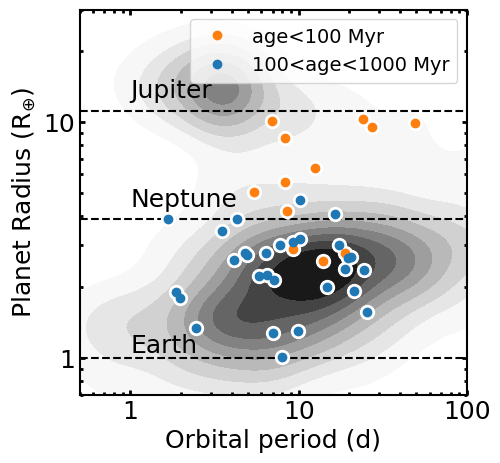

In [14]:
import seaborn as sb
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
from collections import OrderedDict
pl.rcParams['font.size'] = 18

x = 'pl_orbper'
y = 'pl_rade'
idx = np.ones_like(df[x])

porb_lims = (0.5,100)
rp_lims = (0.7,30)

# figsize=None
figsize=(5,5)
fig, ax = pl.subplots(figsize=figsize)

###NExSci
_ = sb.kdeplot(data=df, 
               x=x, 
               y=y,  
               cmap='gray_r', 
               #n_levels=8, 
               log_scale=True, 
               fill=True, 
               ax=ax, 
               zorder=-1
              )
###planets
periods = planets['Planet period'].str.split('±|\+|-', expand=True)[0].astype(float)
radii = planets['Planet radius'].str.split('±|\+|-', expand=True)[0].astype(float)
names = planets.Host.tolist()

for xx,yy,n in zip(periods, radii, names):
    d = hosts[hosts.Host==n].squeeze()
    if len(d)>0:
        age = float(d.Age.split('-')[1])
        if age<100:
            color = 'C1'
            lbl = 'age<100 Myr'
        else:
            color = 'C0'
            lbl = '100<age<1000 Myr'
        ax.plot(xx, yy, 'o', label=lbl, c=color, zorder=11)
    #     #white outline
        ax.plot(xx, yy, 'o', c='w', label='_nolegend_', ms=10, zorder=10)
    
###axes
ax.set_xlim(*porb_lims)
ax.set_ylim(*rp_lims)
ax.set_ylabel('Planet Radius ('+r'R$_{\oplus}$)')
ax.set_xlabel('Orbital period (d)')
ax.tick_params(direction='in', which='both', width=2, bottom=True, top=True, left=True, right=True)
lw=1.5
ax.spines['left'].set_linewidth(lw)
ax.spines['right'].set_linewidth(lw)
ax.spines['top'].set_linewidth(lw)
ax.spines['bottom'].set_linewidth(lw)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

### labels
dx = 1
alpha = 1
Rearth = 1
ax.axhline(Rearth, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rearth+0.05, 'Earth', alpha=alpha)
Rnep = 3.88
ax.axhline(Rnep, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rnep+0.5, 'Neptune', alpha=alpha)
Rjup = 11.2
ax.axhline(Rjup, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rjup+1.5, 'Jupiter', alpha=alpha)
### legend
handles, labels = pl.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
pl.legend(by_label.values(), by_label.keys(), fontsize=14)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [16]:
fig.savefig(f'young_planets_{distance}pc_square.pdf', bbox_inches='tight', dpi=100)